<a href="https://colab.research.google.com/github/a1rishav/pneumonia_detection_from_chest_x_ray/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [0]:
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Dense , Activation
from keras.layers import Conv2D , BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf

# View Data

## Mount drive

In [4]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Validate data directory

In [65]:
!ls "/content/drive/My Drive/ml/pneumonia_detection/data/chest_xray"

test  train  val


## Declare directories

In [0]:
model_dir = "/content/drive/My Drive/ml/pneumonia_detection/models"
data_dir = "/content/drive/My Drive/ml/pneumonia_detection/data/chest_xray"

training_dir = data_dir + "/train"
train_dir_pneumonia = training_dir + "/PNEUMONIA"
train_dir_normal = training_dir + "/NORMAL"

validation_dir = data_dir + "/val"

testing_dir = data_dir + "/test"

model_path = model_dir + "/transferlearning_weights.hdf5"


## View sample images

Pneumonia ----->


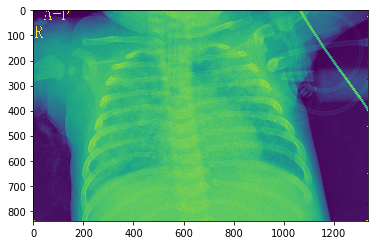

Normal ----->


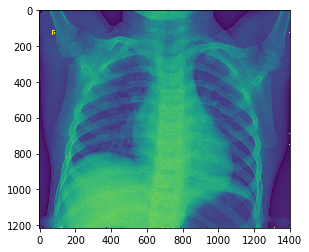

In [67]:
pneumonia_img=mpimg.imread(train_dir_pneumonia + '/person1945_bacteria_4872.jpeg')
imgplot = plt.imshow(pneumonia_img)
print("Pneumonia ----->")
plt.show()
print("Normal ----->")
pneumonia_img=mpimg.imread(train_dir_normal + '/NORMAL2-IM-1423-0001.jpeg')
imgplot = plt.imshow(pneumonia_img)
plt.show()

## Build Model

## Load the base inception model

In [30]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))










87916544/87910968 [==============================] - 9s 0us/step


## Add layers to the base inception model

In [31]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

for layer in base_model.layers:
  layer.trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Compile model

In [0]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training helpers

In [79]:
rescale = 1./255
target_size = (150, 150)
batch_size = 64
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle = False)

Found 5225 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Train

In [72]:
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
epochs = 10
y = train_generator.classes

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)

callbacks = [checkpoint, lr_reduce, early_stopping]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/10
 - 83s - loss: 0.3234 - acc: 0.8607 - val_loss: 3.4460 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /content/drive/My Drive/ml/pneumonia_detection/models/transferlearning_weights.hdf5
Epoch 2/10
 - 66s - loss: 0.2362 - acc: 0.8999 - val_loss: 1.3504 - val_acc: 0.6875

Epoch 00002: val_acc improved from 0.50000 to 0.68750, saving model to /content/drive/My Drive/ml/pneumonia_detection/models/transferlearning_weights.hdf5
Epoch 3/10
 - 76s - loss: 0.2189 - acc: 0.9089 - val_loss: 1.2631 - val_acc: 0.5625

Epoch 00003: val_acc did not improve from 0.68750

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
 - 74s - loss: 0.2098 - acc: 0.9117 - val_loss: 1.4325 - val_acc: 0.6250

Epoch 00004: val_acc did not improve from 0.68750

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/10
 - 77s - loss: 0.2101 - acc: 0.9113 - val_loss: 1.4080 - val_acc: 0.6250

Epoc

## Load the pretrained model

In [0]:
MODEL_FILE = model_dir + '/transferlearning_weights.hdf5'
model = tf.keras.models.load_model(MODEL_FILE)

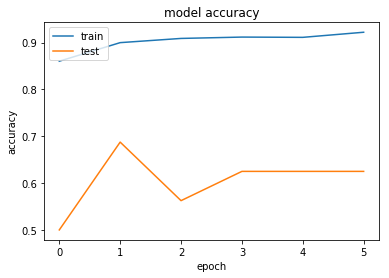

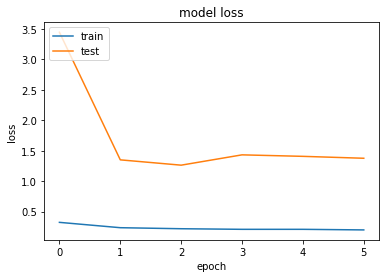

In [74]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
10/10 [==============================] - 8s 762ms/step - loss: 0.4943 - acc: 0.8413
Loss     : 0.49  
Accuracy : 84.13%


results
10/10 [==============================] - 11s 1s/step
------------------------------------------------------------------------------------------
Derived Report
------------------------------------------------------------------------------------------
Precision     : 95.61%
Recall        : 78.21%
F1-Score      : 86.04%
------------------------------------------------------------------------------------------





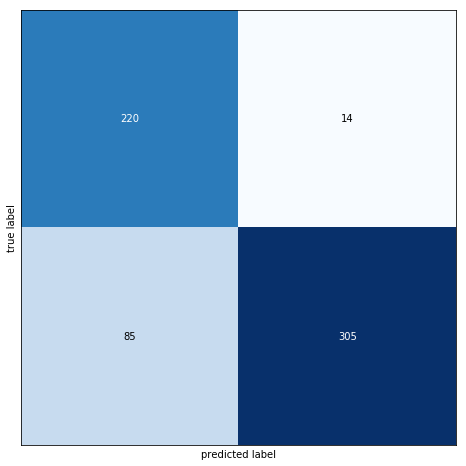

In [82]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("-"*90)
print("Derived Report")
print("-"*90)
print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
print("-"*90)
print("\n\n")

CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

## Predictions on test data

10/10 [==============================] - 8s 771ms/step


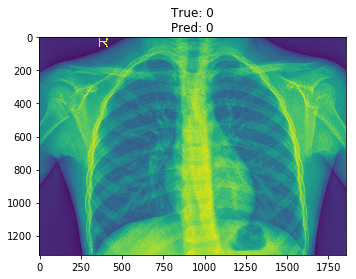

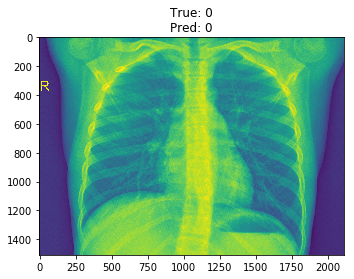

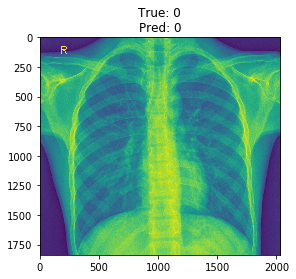

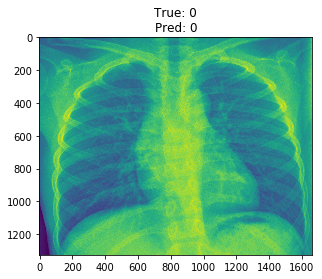

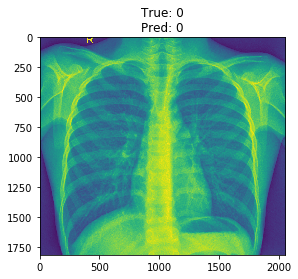

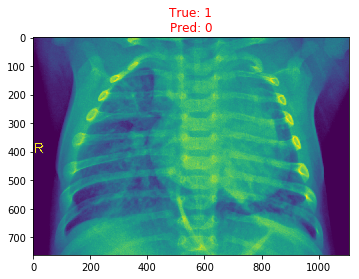

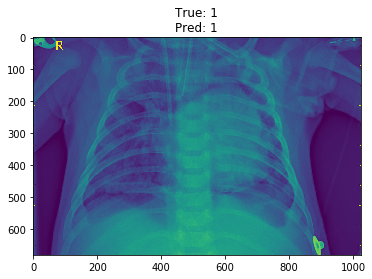

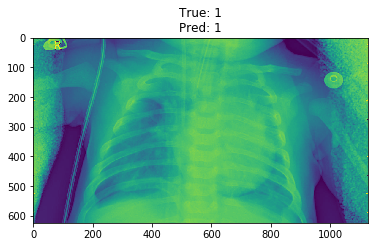

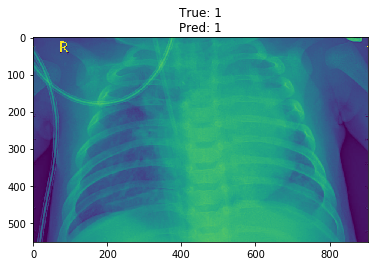

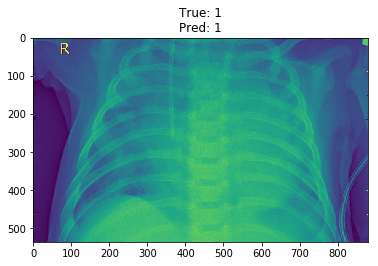

In [113]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

def get_image_and_predictions(y_true, y_pred, gen, image_dir, samplpe_size=5):
  file_name_and_predictions = {}
  
  image_index = 0
  positive_sample_size = negative_sample_size = sample_size
  
  for file_name in gen.filenames:
    if y_true[image_index] == 0 and negative_sample_size > 0:
      file_name_and_predictions[os.path.join(image_dir, file_name)] = [y_true[image_index], y_pred[image_index]]
      negative_sample_size -= 1
                                              
    if y_true[image_index] == 1 and positive_sample_size > 0:
      file_name_and_predictions[os.path.join(image_dir, file_name)] = [y_true[image_index], y_pred[image_index]]
      positive_sample_size -= 1
    
    if positive_sample_size == 0 and negative_sample_size == 0:
      break
    image_index += 1
    
  return file_name_and_predictions
                                              
                                              
for image, predictions in get_image_and_predictions(y_true, y_pred, test_generator, testing_dir).items():
  imgplot = plt.imshow(mpimg.imread(image))
  original = predictions[0]
  predicted = predictions[1]
  
  title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
  if original == predicted:
    plt.title(title_text)
  else:
    plt.title(title_text, color='red')
  plt.show()
  


